In [147]:
import pandas as pd
import numpy as np 
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import glob
import matplotlib.pyplot as plt

In [148]:
data_dict = {
    "alaa" : "team_images/Alaa/*", 
    "aya amr" : "team_images/Aya Amr/*",
    "aya sameh" : "team_images/Aya Sameh/*",
    "ehab" : "team_images/Ehab/*",
    "salman" : "team_images/Salman/*"
}

In [149]:
def face_detection(img):
    face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    # The detectMultiScale() method is used to identify faces of different sizes in the input image.
    face = face_classifier.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200),flags=cv2.CASCADE_SCALE_IMAGE)
# finally, the minSize parameter sets the minimum size of the object to be detected.
# The model will ignore faces that are smaller than the minimum size specified.
    return face

In [150]:
def extract_features(pixel_values,folder_path, label):
    file_names = glob.glob(folder_path)
    for file in file_names:
        gray_img = cv2.imread(file,0)
        face = face_detection(gray_img)
        for (x, y, w, h) in face:
            face_img = gray_img[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (100,100))
            gray_pixels = face_img.flatten().tolist()
            gray_pixels.append(label)
        
        pixel_values.append(gray_pixels)
        

In [151]:
pixel_values = []
for key in data_dict.keys():    
    extract_features(pixel_values, data_dict[key], key)

df = pd.DataFrame(pixel_values)

In [152]:
df.rename(columns={10000:"label"}, inplace=True)

In [153]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,label
0,158,214,212,221,213,217,209,199,206,202,...,153,158,153,160,181,190,187,178,185,alaa
1,112,185,150,206,212,218,217,213,213,201,...,119,116,139,162,162,169,168,170,176,alaa
2,207,218,221,223,218,210,206,206,200,192,...,160,178,184,183,190,161,136,127,74,alaa
3,157,221,213,222,216,215,205,200,201,201,...,154,159,173,193,192,182,183,177,50,alaa
4,216,217,219,212,204,202,208,213,187,187,...,149,164,172,178,182,190,182,131,115,alaa


In [154]:
def perform_pca_faster(faces):
    # Convert the list of face images into a 2D array
    X = np.array(faces).reshape(len((faces)), -1).astype(np.float64)
    # Compute the mean face and subtract it from each face image
    mean_face = np.mean(X, axis=0)
    X -= mean_face
    # Compute the SVD of the centered face images
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    print(Vt.shape)

    # Project the face images onto the lower-dimensional space
    X_pca = np.dot(X, Vt.T)

    return mean_face, Vt, X_pca


In [155]:
mean_face, eigvecs, X_pca = perform_pca_faster(df.drop(columns="label").to_numpy())

(262, 10000)


In [156]:
data = pd.DataFrame(X_pca)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,252,253,254,255,256,257,258,259,260,261
0,-1425.798651,-1074.481908,444.301872,-4.122073,411.447544,-932.512214,455.433810,-849.152547,998.702934,-238.818008,...,26.504293,-18.776041,-6.409120,7.151085,-56.846011,36.439155,-10.548514,25.343639,-45.065154,-7.522871e-13
1,-953.342820,-893.062318,950.785900,154.683827,244.323400,-727.634484,499.228915,-812.856240,869.862847,172.679699,...,-4.119927,-22.804297,47.963462,-16.203792,-5.876089,4.437150,2.779287,31.077524,2.519734,-3.872458e-13
2,-1393.856955,-792.405334,418.408357,-86.533582,170.150363,-1333.494858,526.667509,-670.270367,933.005796,64.579724,...,-29.497938,10.789256,-43.926109,-33.731580,15.330856,8.696994,22.609353,6.155442,-32.030153,-6.146195e-13
3,-1412.003096,-1029.041004,622.838235,87.193838,518.774585,-961.256688,561.332776,-942.621568,919.486270,-134.594128,...,31.506483,-0.775140,-17.519605,16.177425,11.388899,-4.335656,-31.274452,-14.692716,37.317341,-5.879741e-13
4,-1293.442281,-791.380320,398.599834,-17.427822,248.395660,-1118.188398,584.239261,-545.009857,1174.466644,146.826104,...,-28.310814,-0.922235,20.427106,-37.750054,6.913354,-26.232122,-7.871519,-16.811978,60.558161,-4.396483e-13


In [157]:
data["labels"] = df["label"]
data.shape


(262, 263)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns="labels"),data["labels"], stratify=data["labels"], test_size=0.2, random_state=42)

In [159]:
params = {
    "kernel" : ["linear", "poly", "rbf", "sigmoid"],
    'C':[0.01, 0.1, 0.5, 1, 5, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'degree' : range(2,6),
    'decision_function_shape': ["ovo","ovr"]
}
model = GridSearchCV(estimator=SVC(), param_grid=params, n_jobs=-1, cv=5, verbose=1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 896 candidates, totalling 4480 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10, 100],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'degree': range(2, 6), 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=1)

In [160]:
model.best_params_

{'C': 0.01,
 'decision_function_shape': 'ovo',
 'degree': 2,
 'gamma': 1,
 'kernel': 'linear'}

In [161]:
final_model = SVC(C=0.01, gamma=1, kernel="linear", decision_function_shape= "ovo",random_state=42)
final_model.fit(X_train,y_train)

SVC(C=0.01, decision_function_shape='ovo', gamma=1, kernel='linear',
    random_state=42)

In [162]:
import numpy as np
import matplotlib.pyplot as plt

def compute_roc_curve(y_true, y_scores):
    # Sort instances based on scores in descending order
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    total_positives = np.sum(y_true)
    total_negatives = len(y_true) - total_positives

    tpr_values = []  # True Positive Rate
    fpr_values = []  # False Positive Rate

    # Calculate TPR and FPR for different classification thresholds
    tp_count = 0
    fp_count = 0

    for i in range(len(y_scores_sorted)):
        if y_true_sorted[i] == 1:
            tp_count += 1
        else:
            fp_count += 1

        tpr = tp_count / total_positives
        fpr = fp_count / total_negatives

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return fpr_values, tpr_values

In [163]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

def draw_roc_multi_curves(y_true, y_scores, n_classes):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Compute the ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i]= compute_roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves for each class
    plt.figure()
    colors = ['blue', 'red', 'green', 'orange', 'purple']  # Choose colors for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.show()



In [164]:
y_pred = final_model.predict(X_test)
y_scores = final_model.decision_function(X_test)

y_true = np.array(y_test)
y_scores = np.array(y_scores)

print(len(y_true), len(y_scores))


53 53


In [165]:
y_pred = final_model.predict(X_test)
y_scores = final_model.decision_function(X_test)

y_true = np.array(y_test)
y_scores = np.array(y_scores)

print(len(y_true), len(y_scores))


53 53


In [166]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_true_binary = label_encoder.fit_transform(y_true)
# print((y_true_binary), (y_true))

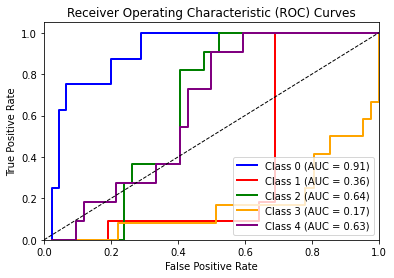

In [167]:
draw_roc_multi_curves(y_true_binary, y_scores, n_classes=5)

In [168]:
from sklearn.metrics import classification_report

In [169]:
cr = classification_report(y_test, final_model.predict(X_test))
print(cr)

              precision    recall  f1-score   support

        alaa       0.89      1.00      0.94         8
     aya amr       0.83      0.91      0.87        11
   aya sameh       1.00      1.00      1.00        11
        ehab       0.92      0.92      0.92        12
      salman       1.00      0.82      0.90        11

    accuracy                           0.92        53
   macro avg       0.93      0.93      0.93        53
weighted avg       0.93      0.92      0.92        53



In [170]:
def predictor(image_path, mean_face, eigvecs):
    gray_img = cv2.imread(image_path,0)
    face = face_detection(gray_img)
    pixel_values = []
    
    for (x, y, w, h) in face:
        face_img = gray_img[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (100,100))
        gray_pixels = face_img.flatten().tolist()
        
    pixel_values.append(gray_pixels)
    
    pixel_values = pd.DataFrame(pixel_values)
    
    X = np.array(pixel_values).reshape(len((pixel_values)), -1).astype(np.float64)
    
    X = X-mean_face
    X_pca = np.dot(X,eigvecs.T)
    
    pred = final_model.predict(X_pca)
    
    print(pred)


In [171]:
predictor("test/IMG-20230518-WA0023.jpg", mean_face, eigvecs)

['aya amr']


[[243 362 276 276]
 [142 164 513 513]]


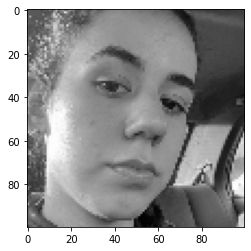

In [172]:
gray_img = cv2.imread("test/IMG-20230518-WA0023.jpg",0)
face = face_detection(gray_img)
print(face)
counter = 0
for (x, y, w, h) in face:
    face_img = gray_img[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, (100,100))
    plt.imshow(face_img, cmap="gray")

In [173]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)